# Compression examples
In this notebook we compare constraints on cosmological parameters obtained with different types of compressions (shapefit, direct).
Notebooks fs_shapefit_examples.ipynb & fs_direct_examples.ipnyb must be run first to produce the samples needed in this notebook.

## BAO compression
As a warm-up, what constraints on $\Omega_m$ do we obtain from an isotropic BAO fit?

In [1]:
from desilike.samples import Chain
from desilike import setup_logging

setup_logging()
chain = Chain.load('_tests/chain_bao_0.npy').remove_burnin(0.3)
z = 1.

[000000.00] [0/1] 02-26 15:34  Chain                     INFO     Loading _tests/chain_bao_0.npy.


In [2]:
import numpy as np

from desilike.theories.primordial_cosmology import Cosmoprimo
from desilike.observables.galaxy_clustering import BAOCompressionObservable
from desilike.likelihoods import ObservablesGaussianLikelihood

quantities = ['qiso']
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=quantities, fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

# Note that you can directly pass arrays as data and covariance, in addition to "quantities"
data = chain.choice(params=quantities, return_type='nparray')
covariance = chain.covariance(params=quantities, return_type='nparray')

observable = BAOCompressionObservable(data=data, covariance=covariance, quantities=quantities, z=z)
likelihood2 = ObservablesGaussianLikelihood(observables=[observable])
#assert np.allclose(likelihood2(Omega_m=0.29), likelihood(Omega_m=0.29))

In [3]:
# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples()
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000000.33] [0/1] 02-26 15:34  BAOCompressionObservable  INFO     Found BAO quantities ['qiso'].
[000000.89] [0/1] 02-26 15:34  Emulator                  INFO     Varied parameters: ['Omega_m'].
[000000.89] [0/1] 02-26 15:34  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities'] outputs.
[000000.89] [0/1] 02-26 15:34  Differentiation           INFO     Varied parameters: ['Omega_m'].
[000001.43] [0/1] 02-26 15:34  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000001.43] [0/1] 02-26 15:34  Differentiation           INFO     Omega_m grid is [0.31119172 0.31319172 0.31519172 0.31719172 0.31919172].


In [4]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.01})

[000001.95] [0/1] 02-26 15:34  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000007.65] [0/1] 02-26 15:34  EmceeSampler              INFO     Diagnostics:
[000007.66] [0/1] 02-26 15:34  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.096; not < 0.01.
[000007.66] [0/1] 02-26 15:34  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.096.
[000007.67] [0/1] 02-26 15:34  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.561.
[000007.68] [0/1] 02-26 15:34  EmceeSampler              INFO     - max Geweke is 0.92.
[000007.68] [0/1] 02-26 15:34  EmceeSampler              INFO     - Geweke p-value is nan.
[000007.68] [0/1] 02-26 15:34  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 15.4.
[000012.79] [0/1] 02-26 15:34  EmceeSampler              INFO     Diagnostics:
[000012.80] [0/1] 02-26 15:34  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 

[Chain(shape=(2100, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

[000040.31] [0/1] 02-26 15:34  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


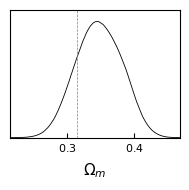

In [5]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.bao.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})

## ShapeFit compression
Now turn to shapefit compression.

In [6]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

chain = Chain.load('_tests/chain_fs_shapefit_0.npy').remove_burnin(0.3)

quantities = ['qpar', 'qper', 'df', 'dm']
observable = ShapeFitCompressionObservable(data=chain, covariance=chain, z=z, quantities=quantities)
likelihood = ObservablesGaussianLikelihood(observables=[observable])
likelihood.all_params['omega_b'].update(fixed=True)

# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples()
emulator.fit()
likelihood.init.update(observables=[emulator.to_calculator()])

[000040.88] [0/1] 02-26 15:34  Chain                     INFO     Loading _tests/chain_fs_shapefit_0.npy.
[000040.90] [0/1] 02-26 15:34  ShapeFitCompressionObservable INFO     Found BAO quantities ['qpar', 'qper'].
[000040.90] [0/1] 02-26 15:34  ShapeFitCompressionObservable INFO     Found FS quantities ['df', 'dm'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000046.79] [0/1] 02-26 15:34  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000046.79] [0/1] 02-26 15:34  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'bao_quantities', 'fs_quantities'] outputs.
[000046.79] [0/1] 02-26 15:34  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000051.90] [0/1] 02-26 15:34  Differentiation           INFO     Using finite-differentiation for parameter h.
[000052.96] [0/1] 02-26 15:34  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000053.99] [0/1] 02-26 15:34  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000053.99] [0/1] 02-26 15:34  Differentiation           INFO     h grid is [0.6696 0.6716 0.6736 0.6756 0.6776].
[000053.99] [0/1] 02-26 15:34  Differentiation           INFO     Omega_m grid is [0.31119172 0.31319172 0.31519172 0.31719172 0.31919172].
[00

In [7]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[000087.09] [0/1] 02-26 15:35  ZeusSampler               INFO     Varied parameters: ['h', 'Omega_m', 'logA'].
[000087.42] [0/1] 02-26 15:35  root                      INFO     Initialising ensemble of 8 walkers...
[000186.60] [0/1] 02-26 15:37  ZeusSampler               INFO     Diagnostics:
[000186.61] [0/1] 02-26 15:37  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0737; not < 0.05.
[000186.62] [0/1] 02-26 15:37  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00181.
[000186.65] [0/1] 02-26 15:37  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.139.
[000186.66] [0/1] 02-26 15:37  ZeusSampler               INFO     - max Geweke is 0.453.
[000186.66] [0/1] 02-26 15:37  ZeusSampler               INFO     - Geweke p-value is 3.52e-05.
[000186.67] [0/1] 02-26 15:37  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 39.5.
[000186.74] [0/1] 02-26 15:37  root                

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000285.91] [0/1] 02-26 15:38  ZeusSampler               INFO     Diagnostics:
[000285.93] [0/1] 02-26 15:38  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0332; < 0.05.
[000285.94] [0/1] 02-26 15:38  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0101.
[000285.96] [0/1] 02-26 15:38  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0992.
[000285.97] [0/1] 02-26 15:38  ZeusSampler               INFO     - max Geweke is 0.386.
[000285.98] [0/1] 02-26 15:38  ZeusSampler               INFO     - Geweke p-value is 0.268.
[000285.99] [0/1] 02-26 15:38  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 85.3.
[000285.99] [0/1] 02-26 15:38  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.138.
[000286.05] [0/1] 02-26 15:38  root                      INFO     Initialising ensemble of 8 walkers...
[000387.14] [0/1] 02-26 15:40  

[Chain(shape=(900, 8), params=ParameterCollection(['h', 'Omega_m', 'logA', 'logposterior', 'omega_b', 'n_s', 'tau_reio', 'm_ncdm', 'N_ur', 'w0_fld', 'wa_fld', 'Omega_k', 'loglikelihood', 'logprior']))]

[000387.25] [0/1] 02-26 15:40  Chain                     INFO     Loading _tests/chain_fs_direct_0.npy.
Removed no burn in
Removed no burn in


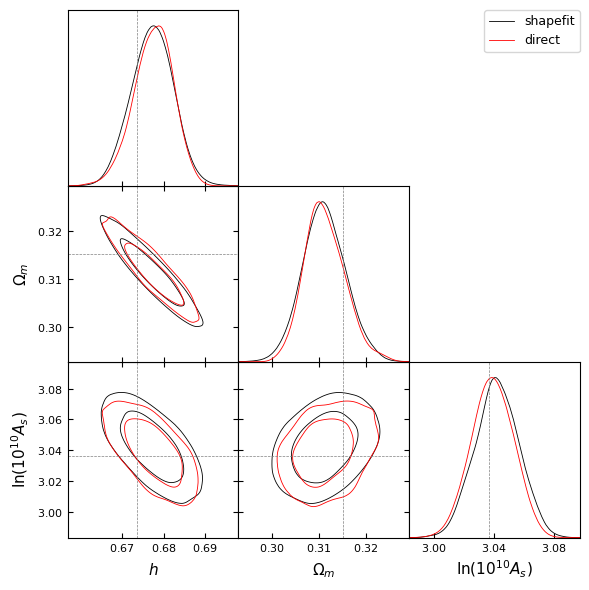

In [8]:
from desilike.samples import plotting
chain_shapefit = sampler.chains[0].remove_burnin(0.1)
chain_direct = Chain.load('_tests/chain_fs_direct_0.npy').remove_burnin(0.5)
plotting.plot_triangle([chain_shapefit, chain_direct], fill=True, labels=['shapefit', 'direct'], markers={'Omega_m': fiducial.Omega0_m, 'h': fiducial.h, 'logA': np.log(10**10 * fiducial.A_s), 'n_s': fiducial.n_s})